# DRL Course 2023 Домашнее задание 1 #

Отчет по выполнению домашнего задания, Nikita Sorokin

## Задание 1 ##

Пользуясь алгоритмом Кросс-Энтропии обучить агента решать задачу Taxi-v3 из Gym. Исследовать гиперпараметры алгоритма и выбрать лучшие.


## Решение ##

Воспользуемся кодом написанным на семинаре.

В среде Taxi-v3 observation кодируется одним числом от 0 до 500, поэтому изменим функции get_state:

```python
def get_state(obs):
    return obs
```

Для поиска наиболее удачных гиперпараметров зафиксируем количество эпох и рассмотрим разные значения квантиля и количества сэмплируемых траекторий. Напишем функцию перебора параметров grid_search:

```python

def grid_search(env, params):
    fig, axs = plt.subplots(figsize=(14, 8))

    axs.set_xlabel('Number of Iterations')
    axs.set_ylabel('Mean Total Rewards')

    labels = [['q_param = ' + f'{q}' + ', trajectory_n = ' + f'{n}' for n in params['trajectory_n']] for q in params['q_param']] 

    result = np.zeros((len(params['q_param']),
                       len(params['trajectory_n'])))

    rewards = []
    for i, q_param in enumerate(params['q_param']):
        for k, trajectory_n in enumerate(params['trajectory_n']):
            new_agent = CrossEntropyAgent(state_n, action_n)
            mean_rewards = train(env, new_agent, q_param, iteration_n, trajectory_n)
            result[i, k] = mean_rewards[-1]
            print(f"{q_param}, {iteration_n}, {trajectory_n}: mean reward = {mean_rewards[-1]}")
            rewards.append(mean_rewards)

            axs.plot(mean_rewards, label=labels[i][k])

    plt.legend()
    plt.savefig('picture1.png')
    plt.show()

```

Полученный график обучения:


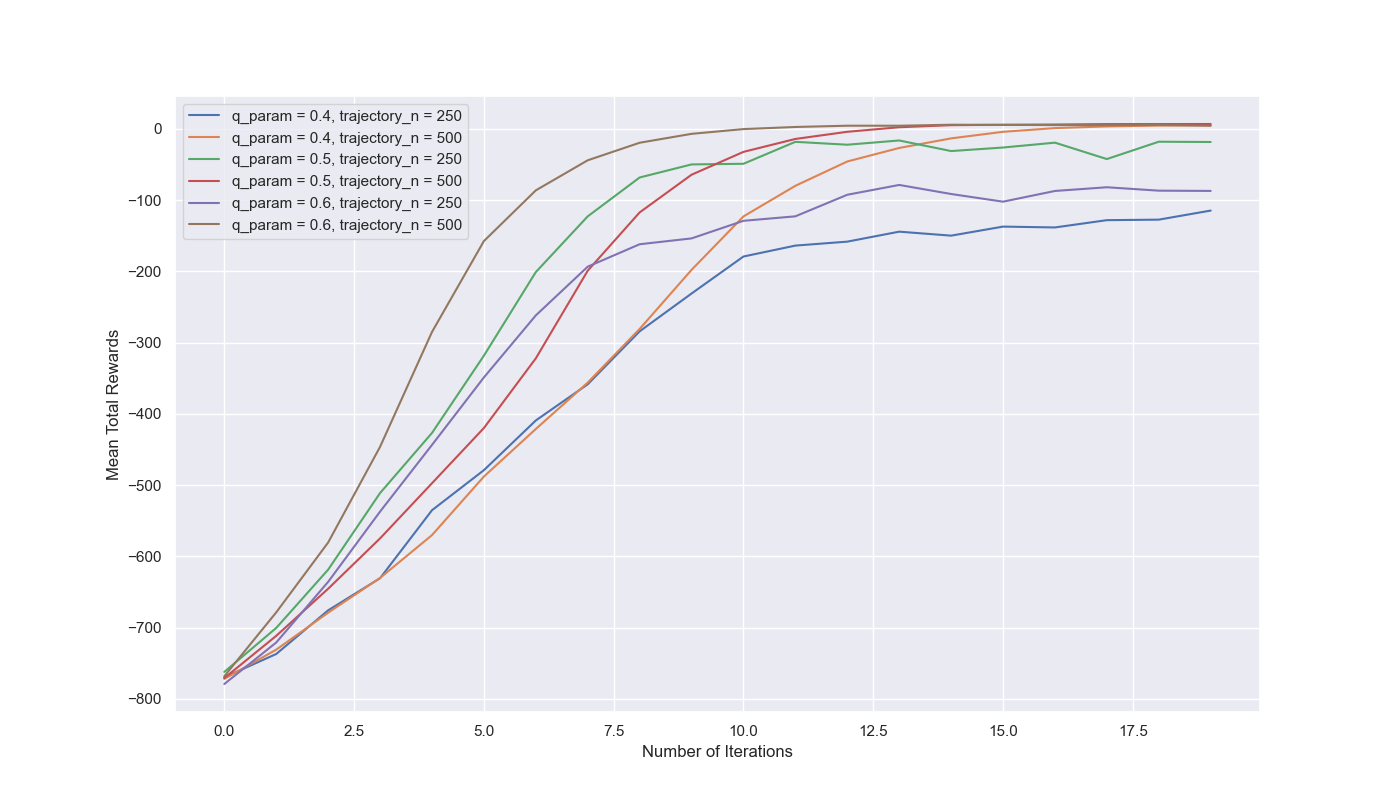

In [2]:
from IPython.display import display, Image
display(Image(filename="picture1.png"))

Для следующих заданий за базовые параметры примем: trajectory_n = 500, q_param = 0.5, iterations_n = 20

## Задание 2 ##

Реализовать алгоритм Кросс-Энтропии с двумя типами сглаживания,  указанными в лекции 1. При выбранных в пункте 1 гиперпараметров сравнить их результаты с результатами алгоритма без сглаживания.

Laplace smoothing:

$$ \pi_{n+1}(a|s) = \frac{{|(a|s) \in T_n| + \lambda}}{{|s \in T_n| + \lambda|A|}} , \lambda > 0 $$

Policy smoothing:

$$ \pi_{n+1}(a|s) \leftarrow \lambda \pi_{n+1}(a|s) + (1 - \lambda) \pi_n(a|s), \quad \lambda \in (0, 1] $$


## Решение ##

Cглаживание Лапласа реализуется в классе агента кросс-энтропии в функции fit при обновлении модели.

Реализация: 

```python

        ...

        if lambda_1 > 0:
            # with laplace smoothing
            for state in range(self.state_n):
                new_model[state] = (new_model[state] + lambda_1) / (np.sum(new_model[state]) + lambda_1 * action_n)
            
        else:
            # w/o laplace smooothing
            for state in range(self.state_n):
                if np.sum(new_model[state]) > 0:
                    new_model[state] /= np.sum(new_model[state])
                else:
                    new_model[state] = self.model[state].copy()

        ...

```

Сглаживание политики реализуется в той же функции после обновления модели с приминением или отсутствием сглаживания Лапласа.

Реализация:

```python

        ...

        if lambda_2 > 0:
            # with policy smoothing
            new_model = lambda_2 * new_model + (1 - lambda_2) * self.model
            
        ...

```

Аналогично, реализуем функции поиска гиперпараметров перебором.

Полученный график обучения:


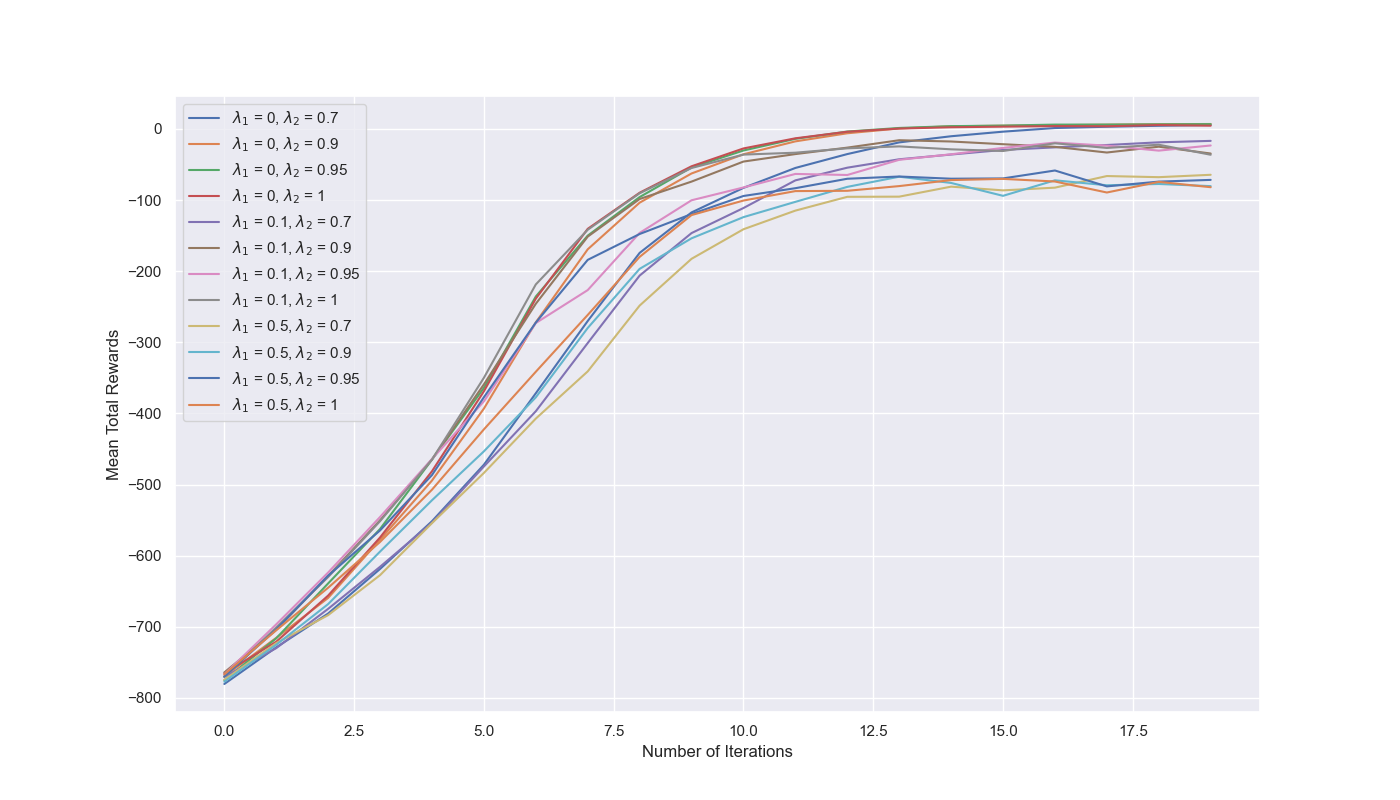

In [3]:
display(Image(filename="picture2.png"))

## Задание 3 ##

Реализовать модификацию алгоритм Кросс-Энтропии для стохастических сред, указанную в лекции 1. Сравнить ее результат с алгоритмами из пунктов 1 и 2.


У стохастической политики $ \pi_{n} $ засемплировать $ \pi_{n,m}, m \in \overline{1, M} $.
Из них получим траектории $ \tau_{m,k}, m \in \overline{1, M}, k \in \overline{1, K} $. Определим 
$$
V_{\pi_{n,m}} = \frac{1}{K} \sum_{k=1}^{K} G(\tau_{m,k}) 
$$
Выберем "элитные" траектории $ T_{n} = \{ \tau_{m,k}, m \in \overline{1, M}, k \in \overline{1, K} : V_{ \pi_{n,m} } > \gamma_{q} \}   $ 
( $ \gamma_{q} $  - квантиль чисел $ V_{ \pi_{n,m} } $ , $ m \in \overline{1, M} $ ). 

## Решение: ## 

Разберемся по порядку с модификацией алгоритма:

1. Сэмплируем M детерминированных политик - матриц с вероятностями равными единицам.
2. По каждой из этих политик получаем K траекторий.
3. Считаем величину $ V_{\pi_{m,n}} $ для каждой из m политик.
4. Выбираем пачки по K траекторий, такие что: $ V_{\pi_{n,m}} > \gamma_q $.
5. Повторяем столько эпох сколько требуется.

Для реализации алгоритма я переписал класс агента кросс-энтропии (лучше было бы наследовать или просто добавить разветвления для стохастических сред в некоторых функциях). Также были изменены функции обучения и получения траекторий:

```python

class CrossEntropyStochasticAgent():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n

        #initialization with equal probabilities
        self.model = np.ones((self.state_n, self.action_n)) / self.action_n
    
    def get_det_policy(self):
        det_policy = np.zeros((self.state_n, self.action_n))
        for state in range(self.state_n):
            action = np.random.choice(np.arange(self.action_n), p=self.model[state])
            det_policy[state, action] = 1
        
        return det_policy

    def get_action(self, state, det_policy=None):
        if det_policy is None:
            action = np.random.choice(np.arange(self.action_n), p=self.model[state])
            return int(action)

        action = np.where(det_policy[state] == 1)[0]
        return int(action)


    def fit(self, elite_trajectories):
        new_model = np.zeros((self.state_n, self.action_n))
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state][action] += 1
            
        for state in range(self.state_n):
            if np.sum(new_model[state]) > 0:
                new_model[state] /= np.sum(new_model[state])
            else:
                new_model[state] = self.model[state].copy()

        self.model = new_model
        return None

```

Измененная функция обучения:

```python

def train(env, agent, q_param, iteration_n, trajectory_n, policies_n):
    rewards = []
    for iteration in tqdm(range(iteration_n)):

        #policy evaluation
        det_policies = [agent.get_det_policy() for _ in range(policies_n)]
        trajectories = [[get_trajectory(env, agent, det_policies[j]) for _ in range(trajectory_n)] for j in range(policies_n)]
        trajectory_rewards = [[np.sum(trajectories[j][i]['rewards']) for i in range(trajectory_n)] for j in range(policies_n)]
        policy_rewards = [np.mean(trajectory_rewards[j]) for j in range(policies_n)]
        mean_total_reward = np.mean(policy_rewards)
        rewards.append(mean_total_reward)
        print('iteration:', iteration, 'policy rewards:', mean_total_reward)

        #policy improvement
        quantile = np.quantile(policy_rewards, q_param)
        elite_trajectories = []
        for index, policy_reward in enumerate(policy_rewards):
            if policy_reward > quantile:
                elite_trajectories.append(trajectories[index])

        elite_trajectories = [item for sublist in elite_trajectories for item in sublist]

        agent.fit(elite_trajectories)

    return rewards


```

К сожалению нормально обучить модель не получилось( . Код переписывался несколько раз остается полагать, что ошибка состоит в багах или недостаточном понимании алгоритма.

График обучения на гиперпараметрах работавших для прошлых пунктов:


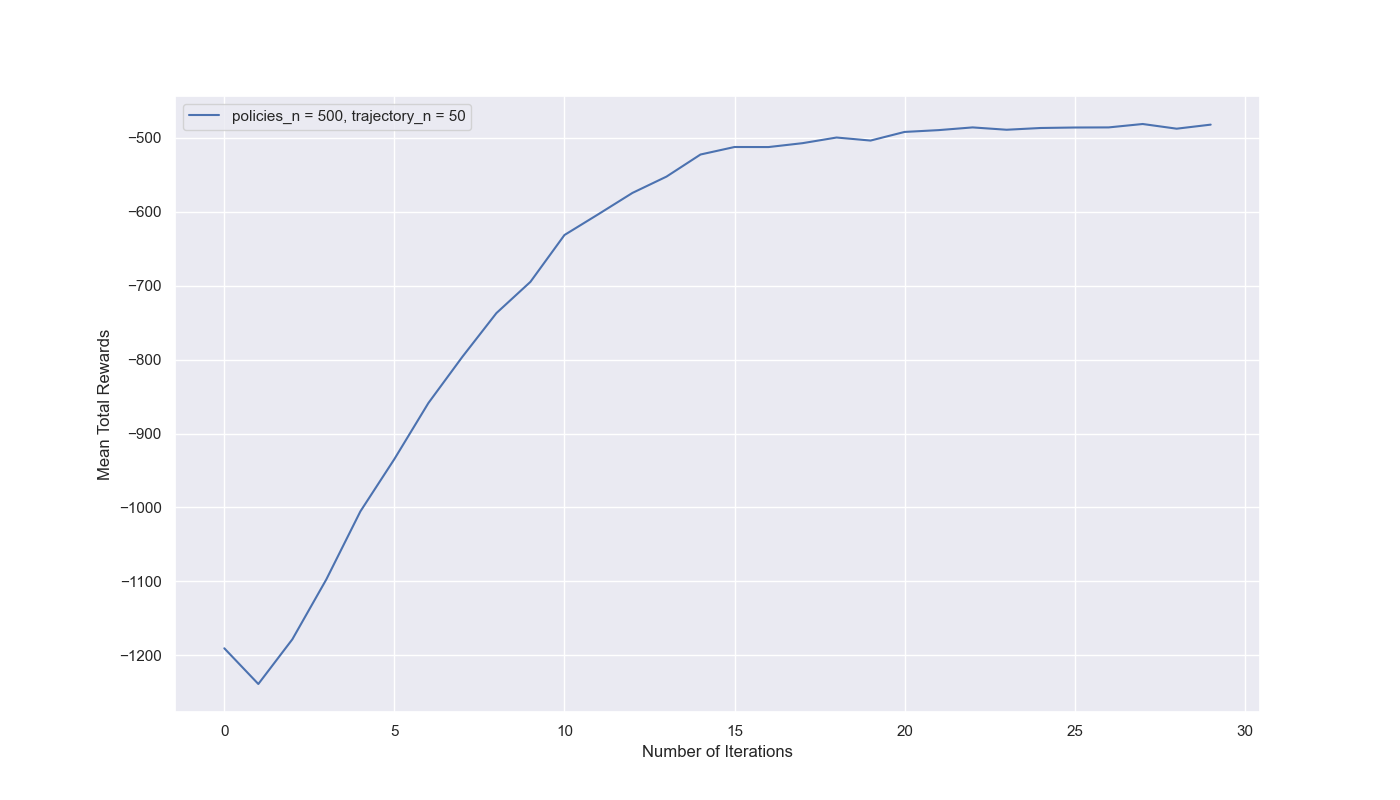

In [4]:
display(Image(filename="picture3.png"))